# Chapter 3 - Deep Dive into Attention Mechanisms 

This notebook teaches and tests LLMs from Scratch Chapter 3 concepts (attention, casual masking, multi-head) with clean Pytorch. 
It builds off of chapter 2 and provides a detailed exploration of attention mechanisms in transformers. 

## Chapter 2 Working with Text Data (recap)

* **Tokenization:** We split raw text into tokens using rules like byte‑pair encoding (BPE).  Tokenization reduces a large vocabulary into manageable units by merging common pairs of characters.
* **Vocabulary & token IDs:** Each distinct token is assigned an integer ID.  These IDs are what we feed into our model.
* **Embedding layer:** A lookup table that turns each token ID into a fixed‑length dense vector.  Similar words end up with similar vectors once the model is trained.
* **Dataloader:** We prepare sequences of token IDs of a fixed length, often with overlapping windows, to feed batches into the model during training.

In [7]:
import math
import torch, torch.nn as nn

"""
Building a basic tokenizer.
"""
text = "Hello world. This is a simple test of our tokenizer."

# 1. Build a character vocabulary
vocab = sorted(list(set(text)))
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}

# 2. Convert characters to token IDs
ids = [stoi[ch] for ch in text]

print('Vocabulary:', vocab)
print('Sample token IDs (first 20):', ids[:20])

# 3. Define embedding layer
vocab_size = len(vocab)
embedding_dim = 8
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# 4. Show how token IDs map to embeddings
# Pick first 10 characters and look up their embeddings
sample_ids = torch.tensor(ids[:10])
emb_vectors = embedding(sample_ids)
print('Embeddings for first 10 tokens (shape):', emb_vectors.shape)
print(emb_vectors)

Vocabulary: [' ', '.', 'H', 'T', 'a', 'd', 'e', 'f', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'w', 'z']
Sample token IDs (first 20): [2, 6, 11, 11, 14, 0, 20, 14, 16, 11, 5, 1, 0, 3, 8, 9, 17, 0, 9, 17]
Embeddings for first 10 tokens (shape): torch.Size([10, 8])
tensor([[ 1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806],
        [-0.9138, -0.6581,  0.0780,  0.5258, -0.4880,  1.1914, -0.8140, -0.7360],
        [ 0.7440, -0.4816, -1.0495,  0.6039, -1.7223, -0.8278,  1.3347,  0.4835],
        [ 0.7440, -0.4816, -1.0495,  0.6039, -1.7223, -0.8278,  1.3347,  0.4835],
        [-1.4570, -0.1023, -0.5992,  0.4771,  0.7262,  0.0912, -0.3891,  0.5279],
        [ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047],
        [-1.9006,  0.2286,  0.0249, -0.3460,  0.2868, -0.7308,  0.1748, -1.0939],
        [-1.4570, -0.1023, -0.5992,  0.4771,  0.7262,  0.0912, -0.3891,  0.5279],
        [ 1.9312,  1.0119, -1.4364, -1.1299, -0.1360,  1.6354,

In [8]:
"""
Comparing Embedding Layers with Linear Layers
embedding layer - a lookup table with shape (vocab_size, embedding_dimension). When you index it with a token ID it returns the corresponding row.
linear layer - fully connected layer with shape (embedding_dimension, vocab_size) and it can perform the same operation 
if you feed it a one-hot vector for each token ID and transpose its weight matrix. 

Using a linear year directly would be much less efficient for large vocabularies. Why? 
Because one-hot vectors are mostly zeros, so the embedding layer will avoid constructing these sparse vectors and simply index into its weight matrix. 
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

#Create a linear layer with weight equal to the embedding weights (transposed)
linear = nn.Linear(vocab_size, embedding_dim, bias=False)
#Copy the weights linear.weight has shape (embedding_dim, vocab_size)
linear.weight.data = embedding.weight.data.clone().t()

token_id = 3

embed_vec = embedding(torch.tensor([token_id])) #shape (1, embedding_dim)

#equivalent linear operation using a one-hot vector
one_hot = F.one_hot(torch.tensor([token_id]), num_classes=vocab_size).float()
lin_vec = linear(one_hot)

print('Embedding vector:', embed_vec)
print('Linear layer output (should match):', lin_vec)

## they produce the same result but the embedding layer is just an efficient way to perform this lookup without constructing one-hot vectors

Embedding vector: tensor([[ 1.2791,  1.2964,  0.6105,  1.3347, -0.2316,  0.0418, -0.2516,  0.8599]],
       grad_fn=<EmbeddingBackward0>)
Linear layer output (should match): tensor([[ 1.2791,  1.2964,  0.6105,  1.3347, -0.2316,  0.0418, -0.2516,  0.8599]],
       grad_fn=<MmBackward0>)


# Mental Model
- Embeddings (B, T, d_model) project to Queries (Q), Keys (K), Values (V)
- scaled dot-product attention is the softmax((Q K^T)/sqrt(d_head)) V
- casual mask (lower-triangular) to prevent looking ahead
- multi-head is to split channels into heads, attend in parallel, concat, and project

In [ ]:
# The embedding matrix learns a semantic space so similar tokens are nearby.

B, T, d_model = 2, 6, 48
x = torch.randn(B, T, d_model, device=device)
x.shape

# Single-Head Self-Attention & Q, K, V 
- W_Q: how to **ask** (what features to look for)
- W_K: how to **advertise** (what features the token contains)
- W_V: what to **carry** (content to pass along)

In a transformer, self-attention allows each position in a sequence to **attend** to other positions to gather contextual information. A single head of self-attention works as follows --

1. For each token vector in the input sequence, we compute three different representations (W_Q, W_K, W_V) which are learned weight matrices. 
2. Then, we compute the attention scores by taking the dot product between each query and all keys to measure similarity. 
3. Then we apply the softmax which converts the scores into a probability distrbution over the positions.
4. Finally, we multiply the value vectors by these probabilities and sum them up. This produces a new representation for each token that incorporates contextual information from the entire (or masked) sequence.

In [9]:
import math

B = 2       # batch size
T = 5       # sequence length
d_model = 16  # input embedding dimension
d_head = 8    # attention head dimension

# random input tensor (batch of sequences)
x = torch.randn(B, T, d_model)

# learnable projection matrices
W_Q = torch.randn(d_model, d_head)
W_K = torch.randn(d_model, d_head)
W_V = torch.randn(d_model, d_head)

# Compute Q, K, V
q = x @ W_Q # shape (B, T, d_head)
k = x @ W_K
v = x @ W_V

# Compute scaled dot-product attention
scores = q @ k.transpose(-2, -1) / math.sqrt(d_head) # shape (B, T, T)
weights = torch.softmax(scores, dim=-1) 

#weighted sum of values
out = weights @ v


print('Input shape:', x.shape)
print('Query shape:', q.shape)
print('Attention weights shape:', weights.shape)
print('Output shape:', out.shape)

Input shape: torch.Size([2, 5, 16])
Query shape: torch.Size([2, 5, 8])
Attention weights shape: torch.Size([2, 5, 5])
Output shape: torch.Size([2, 5, 8])


What does the model learn? 
- The different projection matrices learn to extract different aspects of the input: queries focus on what an information a token needs from the context; keys indicate what information each token provides; values carry the actual information passed along. 
- Attention weights show how strongly each token attends to others. During training on large amounts of text, attention heads learn the linguistic pattersn like subject-verb agreement, long-range dependencies, or phrase boundaries. 
- The scaling factor keeps scores numerically stable - without it the softmax could saturate when d_head is large. 

Let's experiment with the effect of the scaling factor to understand this better.

with scaling -> mean: 0.1667, std: 0.1378
without scaling -> mean: 0.1667, std: 0.3132


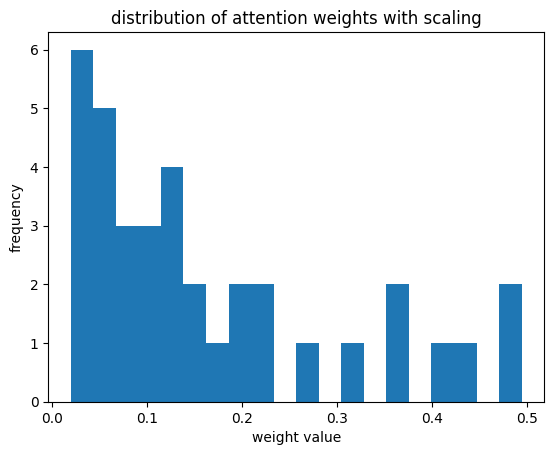

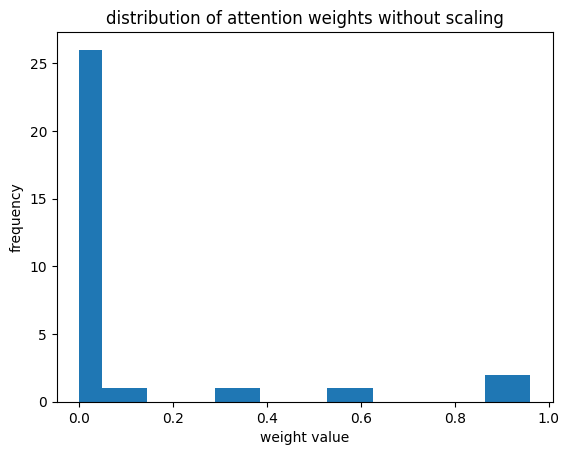

In [10]:
# Experiment: compare attention weights with and without scaling
import matplotlib.pyplot as plt

# Create random Q and K for a single batch and sequence
B, T, d_head = 1, 6, 16
q_exp = torch.randn(B, T, d_head)
k_exp = torch.randn(B, T, d_head)

# compute the raw scores
scores_raw = q_exp @ k_exp.transpose(-2, -1)

#add scaling
weights_scaled = torch.softmax(scores_raw / math.sqrt(d_head), dim=-1)

#without scaling
weights_without_scale = torch.softmax(scores_raw, dim=-1)

#Compute the statistics
def describe(weights, name):
    mean = weights.mean().item()
    std = weights.std().item()
    print(f"{name} -> mean: {mean:.4f}, std: {std:.4f}")

describe(weights_scaled, 'with scaling')
describe(weights_without_scale, 'without scaling')

flat_scaled = weights_scaled.view(-1).detach().numpy()
flat_no_scale = weights_without_scale.view(-1).detach().numpy()

plt.hist(flat_scaled, bins=20)
plt.title('distribution of attention weights with scaling')
plt.xlabel('weight value')
plt.ylabel('frequency')
plt.show()

plt.hist(flat_no_scale, bins=20)
plt.title('distribution of attention weights without scaling')
plt.xlabel('weight value')
plt.ylabel('frequency')
plt.show()

Without scaling, the distribution of attention weights becomes more peaked (higher variance), meaning one or two tokens dominate the attention. The scaling results in a more balanced distribution, allowing the model to consider multiple relevant tokens instead of focusing narrowly.